<h3>Creating a custom gym environment for offloading process from IOT devices

# Requirements 
pip install numpy matplotlib tensorflow==2.13 keras==2.1.3 keras-rl2 gymnasium

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from gymnasium import Env
from gymnasium.spaces import Discrete,Box

<h3> UAVS can be at different height as distance is calculated using all three coordinates 

In [46]:
class UAV():
    def __init__(self):
        # position is a integer variable
        self.position=random.randint(0,30)

In [47]:
class MobileDevice:
    def __init__(self, processes, position):  # Take pre-generated data
        self.processes = processes
        self.position = position


In [48]:
mobile_list=[]
'''Initialize the positions of different mobile agents in your current environemnt'''
num_mobiles=10
for i in range(num_mobiles):
    processes = [80 * 10**6 for _ in range(1)]
    #position = random.randint(0, 400)
    if i % 2 == 0:
        position = random.randint(0, 100)
    else:
        position = random.randint(200, 400)
    mobile_list.append((processes, position))


In [49]:
time_taken_after_training=[]
energy_consumed_after_training=[]

In [50]:
class OffloadingEnv(Env):

    def __init__(self):
        self.reward_when_all_offload=0
        self.energy_when_all_offload=0
        self.time=0
        self.energy=0
        # Define action space (2 actions: execute locally or offload)
        self.action_space = Discrete(2)
        # Initializing the Uavs in the environment
        self.uav_list = [UAV() for _ in range(1)]
        # The new state space is the mobile index 
        self.observation_space = Box(low=0, high=400, shape=(1,), dtype=np.float32)
        self.state = np.array([0])
        print(self.state.shape)
        # global mobile_list
        self.mobile_list = mobile_list #list to store the data

        self.initial_mobile_data=self.mobile_list[:]

    def step(self, action):
        reward=0
        info = {}
        mobile_index=0
        current_process_size=self.mobile_list[mobile_index].processes[0]
        current_process_postion=self.mobile_list[mobile_index].position

        # uav = int(self.state[2] % len(self.uav_list))
        uav=0

        # remove the process sent for execution
        self.mobile_list[mobile_index].processes.pop(0)
        
        # if the agent does not have any other processes then remove the agent
        if(len(self.mobile_list[mobile_index].processes)==0):
            self.mobile_list.pop(mobile_index)        
            
        distance=abs(current_process_postion-self.uav_list[uav].position)

        # change the current state to the next state
        self.state = np.array([distance])

        done=False
        
        B = 10 * 10**6
        P_up = 0.1
        sigma_squared = 10**-10
        P_NLOS = 10**-8
        fading_factor = 1
        K = 1 * 10**-28
    
        if distance != 0:
            channel_gain = (10**-5) / distance
        else:
            channel_gain = 1000
    
        snr = float((P_up * channel_gain * fading_factor) / (sigma_squared + P_NLOS))
        snr=round(snr,2)
        transmission_rate = float(B * math.log2(1 + snr))
        transmission_rate = round(transmission_rate, 2)
    
        if transmission_rate == 0:
            transmission_time = float('inf')
        else:
            transmission_time = float(current_process_size / transmission_rate)
    
        calculation_time_UAV = round(current_process_size * 1000 / (4 * 10**9),2)
        calculation_time_local = round(current_process_size * 1000 / (2 * 10**9),2)
    
        energy_offloading = P_up * transmission_time + K * (4 * 10**9)**3 * calculation_time_UAV
        energy_local = K * (2 * 10**9)**3 * calculation_time_local
    
        offload_cost = round(10 * (calculation_time_UAV + transmission_time) + energy_offloading + 1,2)
        local_cost = round(10 * calculation_time_local + energy_local,2)

        if action == 1:  # Offload
            reward=-offload_cost
            if offload_cost<local_cost:
                print("correct execution ")
            self.time+=calculation_time_UAV+transmission_time
            self.energy+=energy_offloading
            print('offload')

        if action == 0:  # Local
            reward=-local_cost
            if(local_cost<offload_cost):
                print("correct execution")
            self.time+=calculation_time_local
            self.energy+=energy_local
            print('local')
        
  
        self.reward_when_all_local-=local_cost
        self.reward_when_all_offload-=offload_cost
        # Check if the episode is done
        if len(self.mobile_list)==0:
            done=True
            return self.state, reward, done, info

        if done:
            self.state = np.array([0]) # Set to default when done
        return self.state, reward, done, info

    def reset(self):
        # Reset starting state
        self.state = np.array([0])
        self.uav_list=self.uav_list = [UAV() for _ in range(1)]
        self.mobile_list = []  # Clear the old list
        for processes, position in self.initial_mobile_data:
            self.mobile_list.append(MobileDevice(processes[:], position))
        # ''' Randomly choose a mobile and assign it  a new random position to include the dynamic behaviour of the position of mobile devices '''
        # self.mobile_list[random.randint(0,19)].position=random.randint(0,100)
        self.reward_when_all_local=0
        self.reward_when_all_offload=0
        global time_taken_after_training
        time_taken_after_training.append(self.time)
        global energy_consumed_after_training
        energy_consumed_after_training.append(self.energy)
        self.time=0
        self.energy=0
        
        return self.state


In [ ]:
# Main loop for testing
# lets observe the time total and rewards when the agent have learned nothing
if __name__ == "__main__":
    env = OffloadingEnv()
    rewards_random=[]
    rewards_offload=[]
    rewards_local=[]

    episodes = 30
    for episode in range(1,episodes):
        state = env.reset()  # Reset environment at the start of each episode
        done = False
        score = 0

        while not done:
            action= env.action_space.sample()  # Sample random action
            n_state, reward, done, info = env.step(action)  # Step through environment
            score += reward  # Accumulate reward
        rewards_random.append(score)
        rewards_offload.append(env.reward_when_all_offload)
        rewards_local.append(env.reward_when_all_local)
        
        print(f"Episode: {episode}, Total_reward: {env.reward_when_all_local}")

<h1> Implementing DQN using Keras

In [52]:
import numpy as np
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Input,Activation,Concatenate
from tensorflow.keras.optimizers import legacy

In [53]:
states=env.observation_space.shape
actions=env.action_space.n
states

(1,)

In [54]:
from keras import __version__
import tensorflow as tf
tf.keras.__version__ = __version__

In [55]:
from rl.agents import DQNAgent ,SARSAAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

In [56]:
# Build neural network
def build_model():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(1, 1)))  # Input is one-dimensional (1, 1)
    model.add(Flatten())  # Flatten the (1, 1) input into a single dimension
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='linear'))  # Output layer has 2 units for local and offload costs
    return model

model_dqn=build_model()

In [57]:
# # To get the weights of the entire model
#weights = model_dqn.get_weights()

# # Print the weights of the model
# for i, weight in enumerate(weights):
#     print(f"Layer {i} weights shape: {weight.shape}")
#     print(weight)  # This will print the weights for each layer


In [58]:
# model.summary()

In [59]:
policy = EpsGreedyQPolicy(eps=0.05)  # Start with 5% random actions
memory = SequentialMemory(limit=1000, window_length=1)

In [60]:

# learning_rates = [1e-1,1e-2,1e-3]
# for lr in learning_rates:
#     model_dqn=build_model()
#     dqn = DQNAgent(model=model_dqn, memory=memory, policy=policy,
#             nb_actions=actions, nb_steps_warmup=100, 
#             target_model_update=1e-1, gamma=0)
    
#     dqn.compile(legacy.Adam(learning_rate=lr), metrics=['mae'])

#     try:
#         scores = dqn.fit(env, nb_steps=5000, visualize=False, verbose=1)
#     except ValueError as e:
#         print("An error occurred during training:", e)
#         print("Environment State:", env.state)

    
#     # Extract episode rewards from scores.history
#     rewards = scores.history['episode_reward']
#     # Plot rewards for the current learning rate
#     plt.plot(rewards, label=f'LR={lr}')

# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.title('Rewards per Episode during DQN Training')
# plt.legend(loc='lower center', bbox_to_anchor=(0, 1)) 
# plt.show()

In [61]:
model_dqn=build_model()

In [62]:
dqn = DQNAgent(model=model_dqn, memory=memory, policy=policy,
            nb_actions=actions, nb_steps_warmup=100, 
            target_model_update=1e-1, gamma=0)
dqn.compile(legacy.Adam(learning_rate=1e-2), metrics=['mae'])

In [63]:
dqn.forward(np.array([247]))


0

In [64]:
dqn.forward(np.array([16]))

0

In [65]:
model_dqn.predict(np.array([[[106]]]))

array([[2.008048  , 0.76511884]], dtype=float32)

In [66]:
time_taken_after_training=[]
energy_consumed_after_training=[]

In [ ]:
try:
    scores = dqn.fit(env, nb_steps=5000, visualize=False, verbose=1)
except ValueError as e:
    print("An error occurred during training:", e)
    # Debugging information
    print("Environment State:", env.state)
# After training the DQN agent
episode_rewards_dqn_train = scores.history['episode_reward']
plt.plot(episode_rewards_dqn_train)
plt.xlabel("Episodes")
plt.ylabel("rewards")

Text(0, 0.5, 'Time Taken')

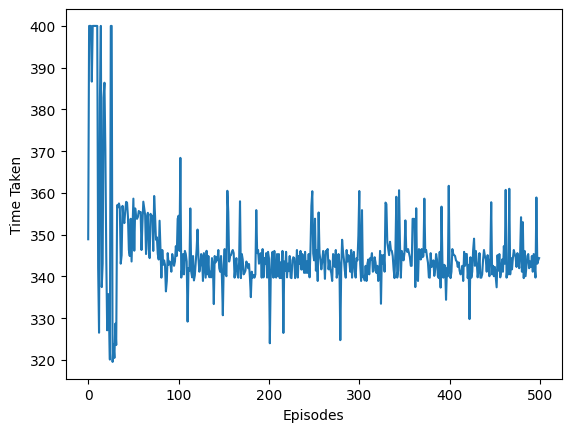

In [68]:
plt.plot(time_taken_after_training)
plt.xlabel("Episodes")
plt.ylabel("Time Taken")

Text(0, 0.5, 'Energy Consumed')

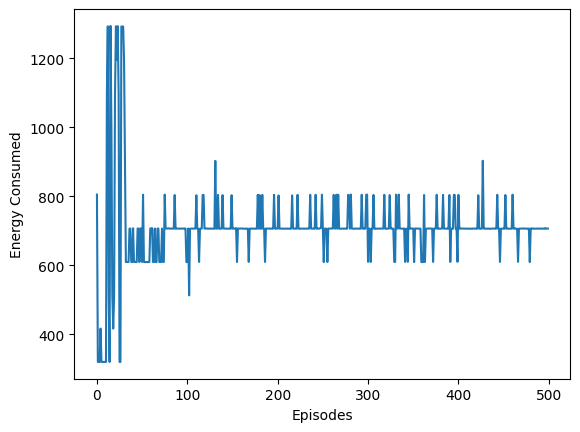

In [69]:
plt.plot(energy_consumed_after_training)
plt.xlabel("Episodes")
plt.ylabel("Energy Consumed")

In [70]:
scores = dqn.test(env, nb_episodes=10, visualize=False)
print("Test Scores:", scores)
episode_rewards_dqn = scores.history['episode_reward']

Testing for 10 episodes ...
local
correct execution
local
correct execution 
offload
correct execution
local
correct execution 
offload
correct execution
local
correct execution 
offload
correct execution
local
correct execution 
offload
correct execution
local
Episode 1: reward: -4121.400, steps: 10
local
correct execution
local
correct execution 
offload
correct execution
local
correct execution 
offload
correct execution
local
correct execution 
offload
correct execution
local
correct execution 
offload
correct execution
local
Episode 2: reward: -4169.430, steps: 10
local
correct execution
local
correct execution 
offload
correct execution
local
correct execution 
offload
correct execution
local
correct execution 
offload
correct execution
local
correct execution 
offload
correct execution
local
Episode 3: reward: -4161.480, steps: 10
local
correct execution
local
correct execution 
offload
correct execution
local
correct execution 
offload
correct execution
local
correct execution 

<h1> Implementing Sarsa using Keras-rl

In [71]:
# learning_rates = [1e-1,1e-2,1e-3]

# for lr in learning_rates:
#     model_sarsa=build_model()
#     sarsa = SARSAAgent(model=model_sarsa, nb_actions=actions, nb_steps_warmup=10, policy=policy,gamma=0)
#     sarsa.compile(legacy.Adam(lr=lr), metrics=['mae'])

#     try:
#         scores = sarsa.fit(env, nb_steps=4000, visualize=False, verbose=1)
#     except ValueError as e:
#         print("An error occurred during training:", e)
#         print("Environment State:", env.state)

    
#     # Extract episode rewards from scores.history
#     rewards = scores.history['episode_reward']


#     # Plot rewards for the current learning rate
#     plt.plot(rewards, label=f'LR={lr}')
    
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.title('Rewards per Episode during SARSA Training')
# plt.legend(loc='lower center', bbox_to_anchor=(0, 1)) 

# plt.show()


In [72]:
time_taken_after_training_dqn=time_taken_after_training
energy_consumed_after_training_dqn=energy_consumed_after_training
time_taken_after_training=[]
energy_consumed_after_training=[]

In [73]:
model_sarsa=build_model()

In [74]:

sarsa = SARSAAgent(model=model_sarsa, nb_actions=actions, nb_steps_warmup=10, policy=policy,gamma=0)
sarsa.compile(legacy.Adam(lr=1e-2), metrics=['mae'])


c:\Users\letsc\OneDrive\Desktop\ML Python\offloading\lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
try:
    scores=sarsa.fit(env, nb_steps=5000, visualize=False, verbose=2)
except ValueError as e:
    print("An error occurred during training:", e)
    # Debugging information
    print("Environment State:", env.state)
episode_rewards_sarsa_train= scores.history['episode_reward']
plt.plot(episode_rewards_sarsa_train)
plt.xlabel("Episodes")
plt.ylabel("rewards")

Text(0, 0.5, 'Energy Consumed')

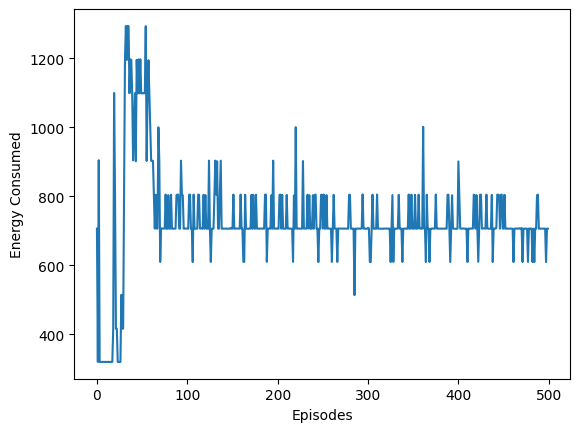

In [76]:
plt.plot(energy_consumed_after_training)
plt.xlabel("Episodes")
plt.ylabel("Energy Consumed")

Text(0, 0.5, 'Time Taken')

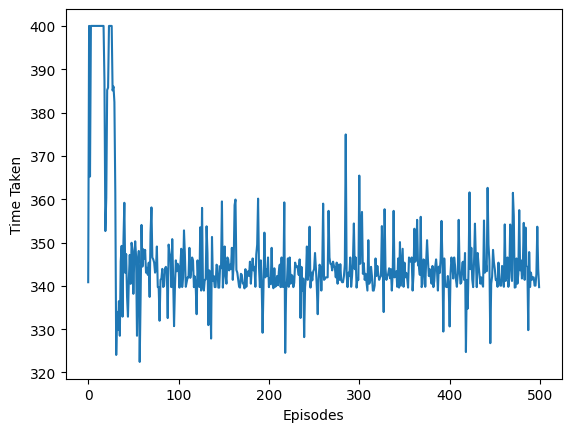

In [77]:
plt.plot(time_taken_after_training)
plt.xlabel("Episodes")
plt.ylabel("Time Taken")

In [78]:
history_sarsa=sarsa.test(env, nb_episodes=10, visualize=False)
episode_rewards_sarsa = history_sarsa.history['episode_reward']


Testing for 10 episodes ...
local
correct execution
local
correct execution 
offload
offload
correct execution 
offload
offload
correct execution 
offload
offload
correct execution 
offload
correct execution
local
Episode 1: reward: -4444.200, steps: 10
local
offload
correct execution 
offload
offload
correct execution 
offload
offload
correct execution 
offload
offload
correct execution 
offload
correct execution
local
Episode 2: reward: -4609.840, steps: 10
local
offload
correct execution 
offload
offload
correct execution 
offload
offload
correct execution 
offload
offload
correct execution 
offload
correct execution
local
Episode 3: reward: -4546.130, steps: 10
local
offload
correct execution 
offload
offload
correct execution 
offload
offload
correct execution 
offload
offload
correct execution 
offload
correct execution
local
Episode 4: reward: -4548.860, steps: 10
local
correct execution
local
correct execution 
offload
offload
correct execution 
offload
offload
correct executio

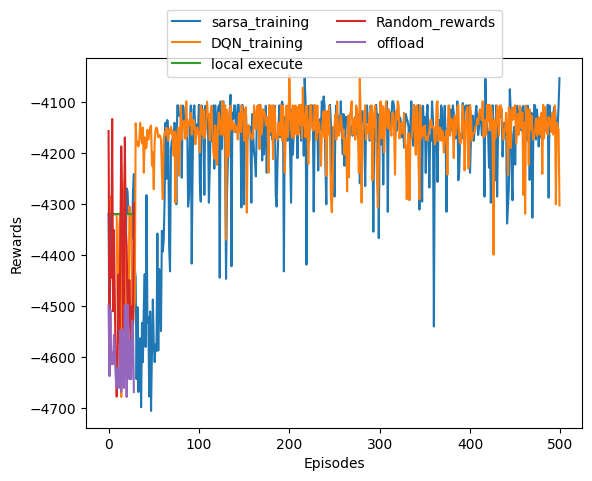

In [79]:
plt.plot(episode_rewards_sarsa_train,label='sarsa_training')
plt.plot(episode_rewards_dqn_train,label='DQN_training')
plt.plot(rewards_local,label='local execute')
plt.plot(rewards_random,label='Random_rewards')
plt.plot(rewards_offload,label='offload')
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.show()

In [80]:
# plt.plot(rewards_local,label='local execute')
# plt.plot(rewards_random,label='Random_rewards')
# plt.plot(rewards_offload,label='offload')
# plt.plot(episode_rewards_dqn,label='DQN')
# plt.plot(episode_rewards_sarsa,label='Sarsa')
# plt.xlabel("Episodes")
# plt.ylabel("rewards")
# plt.legend(loc='upper left', bbox_to_anchor=(0, 1)) 
# plt.show()


In [81]:
distances=[]
for i in mobile_list:
    distances.append(i[1])

In [82]:
distances

[75, 225, 92, 372, 98, 376, 92, 348, 25, 297]

In [83]:
# import numpy as np
# import math

# Constants
B = 10 * 10**6
P_up = 0.1
sigma_squared = 10**-10
P_NLOS = 10**-8
fading_factor = 1
K = 1 * 10**-28
current_process_size = 80 * 10**6  # Constant process size

def calculate_offload(distance):
    if distance != 0:
        channel_gain = (10**-5) / abs(distance)
    else:
        channel_gain = 1000

    snr = float((P_up * channel_gain * fading_factor) / (sigma_squared + P_NLOS))
    snr = round(snr, 2)
    transmission_rate = float(B * math.log2(1 + snr))
    transmission_rate = round(transmission_rate, 2)

    if transmission_rate == 0:
        transmission_time = float('inf')
    else:
        transmission_time = float(current_process_size / transmission_rate)

    calculation_time_UAV = round(current_process_size * 1000 / (4 * 10**9), 2)

    energy_offloading = P_up * transmission_time + K * (4 * 10**9)**3 * calculation_time_UAV
    return calculation_time_UAV + transmission_time, energy_offloading

def calculate_local():
    calculation_time_local = round(80 * 10**6 * 1000 / (2 * 10**9), 2)
    energy_local = K * (2 * 10**9)**3 * calculation_time_local
    return calculation_time_local, energy_local


time_local = 0
energy_local = 0
time_offload = 0
energy_offload = 0

for distance in distances:
    local_time, local_energy = calculate_local()
    offload_time, offload_energy = calculate_offload(distance)
    
    time_local += local_time
    energy_local += local_energy
    time_offload += offload_time
    energy_offload += offload_energy

# print("Time")
print(time_local)
# print(time_offload)
# print(np.min(time_taken_after_training)) #Make sure time_taken_after_training is defined
# print("energy consumed")
# print(energy_local)
print(energy_offload)
# print(np.mean(energy_consumed_after_training)) #Make sure energy_consumed_after_training is defined

400.0
1293.7445754650391


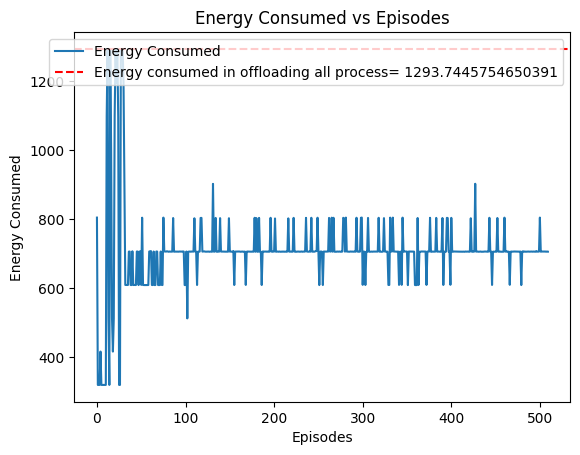

In [84]:
# Example data
episodes = range(len(energy_consumed_after_training_dqn))  # Assuming 'energy_consumed_after_training' is defined
target_value = energy_offload  # Value for the horizontal line

# Plotting
plt.plot(episodes, energy_consumed_after_training_dqn, label="Energy Consumed")
plt.axhline(y=target_value, color='r', linestyle='--', label=f"Energy consumed in offloading all process= {target_value}")

# Adding labels and legend
plt.xlabel("Episodes")
plt.ylabel("Energy Consumed")
plt.title("Energy Consumed vs Episodes")
plt.legend()

# Show the plot
plt.show()


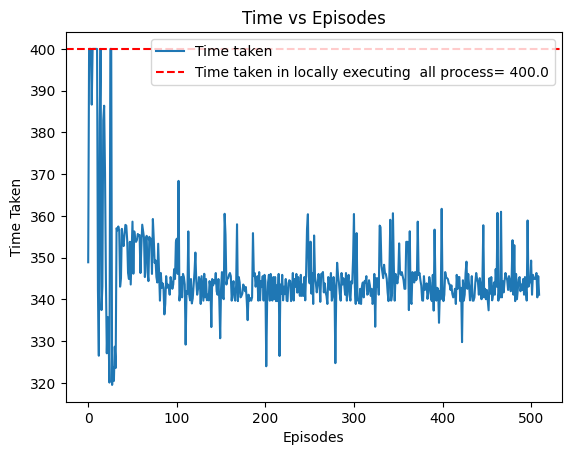

In [85]:
episodes = range(len(time_taken_after_training_dqn))  # Assuming 'energy_consumed_after_training' is defined
target_value = time_local  # Value for the horizontal line

# Plotting
plt.plot(episodes, time_taken_after_training_dqn, label="Time taken")
plt.axhline(y=target_value, color='r', linestyle='--', label=f"Time taken in locally executing  all process= {target_value}")

# Adding labels and legend
plt.xlabel("Episodes")
plt.ylabel("Time Taken")
plt.title("Time vs Episodes")
plt.legend()

# Show the plot
plt.show()
